In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sns
import sys
sys.path.append("../")
from DSP_prototype.DSP_algorithms import stft

2025-01-18 00:48:13.913250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737157693.930022   86915 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737157693.934879   86915 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 00:48:13.951293: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Informacje o zbiorze danych "speech_commands"

## Etykiety
W zbiorze danych znajdują się pliki audio próbkowane z częstotliwością $f=16$kHz. Każdemu plikowi przypisana jest jedna z 12 dostępnych klas, które numerowane są w następujący sposób:

- 0 - down
- 1 - go
- 2 - left
- 3 - no
- 4 - off
- 5 - on
- 6 - right
- 7 - stop
- 8 - up
- 9 - yes
- 10 - silence
- 11 - unknown

In [3]:
sample_rate = 16000
label_strings = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes", "silence", "unknown"]
selected_labels = [1, 2, 3, 6, 7, 9, 10, 11]
selected_labels_dict = {x:i for i, x in enumerate(selected_labels)}
NUM_CLASSES = len(selected_labels)
commands = [label_strings[x] for x in selected_labels]

In [4]:
dataset, info = tfds.load('speech_commands', with_info=True, as_supervised=True, split="test+validation+train")
print(f"Full dataset length: {len(dataset)}")

exclude_classes = [x for x in range(12) if x not in selected_labels]
dataset = dataset.shuffle(10000, seed=2137)

I0000 00:00:1737111681.734730    9313 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 Super, pci bus id: 0000:01:00.0, compute capability: 7.5


Full dataset length: 100503


In [5]:
def split_data_and_labels(dataset, length):
    data = []
    labels = []
    i = 0
    unknown_counter = 0
    for feature, label in dataset:
        if i == length:
            break
            
        pcm = feature.numpy()
        pcm_padded = np.pad(pcm, (0, sample_rate - len(pcm)), 'constant', constant_values=0)
        pcm_padded = pcm_padded.astype(np.float32)
        pcm_padded = librosa.resample(pcm_padded, orig_sr=16e3, target_sr=8e3)
        label = int(label.numpy())
        if label in selected_labels:
            if label == 11 and unknown_counter < 5:
                unknown_counter += 1
                
            if (label == 11 and unknown_counter == 5) or label != 11:
                data.append(pcm_padded)
                labels.append(selected_labels_dict.get(label))
                i += 1
                unknown_counter = 0
    return np.vstack(data), np.vstack(labels)


In [6]:
data, labels = split_data_and_labels(dataset, len(dataset))
NEW_DATASET_LENGTH = len(data)
print(f"Filtered length: {NEW_DATASET_LENGTH}")

2025-01-17 12:01:24.489336: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-17 12:02:15.268999: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Filtered length: 30069


# Split into data and labels

In [7]:
TRAIN_PART = 0.7
VAL_PART = 0.1
TEST_PART = 0.2

train_data = data[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
train_labels = labels[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
TRAIN_LEN = len(train_data)

val_data = data[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
val_labels = labels[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
VAL_LEN = len(val_data)

test_data = data[TRAIN_LEN+VAL_LEN:]
test_labels = labels[TRAIN_LEN+VAL_LEN:]
TEST_LEN = len(test_data)

print(f"Train data length: {TRAIN_LEN}")
print(f"Validation data length: {VAL_LEN}")
print(f"Test data length: {TEST_LEN}")
print(f"Full dataset length: {NEW_DATASET_LENGTH}")

Train data length: 21048
Validation data length: 3006
Test data length: 6015
Full dataset length: 30069


In [8]:
train_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in train_data]).astype(np.float32)
valid_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in val_data]).astype(np.float32)
test_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in test_data]).astype(np.float32)

In [9]:
train_data = train_data.reshape(len(train_data), train_data[0].shape[0], train_data[0].shape[1], 1)
valid_data = valid_data.reshape(len(valid_data), valid_data[0].shape[0], valid_data[0].shape[1], 1)
test_data = test_data.reshape(len(test_data), test_data[0].shape[0], test_data[0].shape[1], 1)

In [4]:
interpreter = tf.lite.Interpreter(model_path="tra_model_for_optimization5.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Data Type:", input_details[0]['dtype'])

Input Shape: [ 1 32 32  1]
Input Data Type: <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [167]:
test_data.shape

(6015, 129, 61, 1)

In [201]:
y_pred = []
correctly = 0
for sample, y_true in zip(test_data, test_labels):
    interpreter.set_tensor(input_details[0]['index'], tf.expand_dims(sample, 0))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # print(output_data)
    predicted_class = np.argmax(output_data)
    if predicted_class == y_true:
        correctly += 1
    y_pred.append(predicted_class)
    print(f"Y_pred={predicted_class} | Y_true={y_true[0]}")

Y_pred=5 | Y_true=5
Y_pred=0 | Y_true=7
Y_pred=1 | Y_true=6
Y_pred=0 | Y_true=0
Y_pred=7 | Y_true=7
Y_pred=0 | Y_true=4
Y_pred=3 | Y_true=7
Y_pred=1 | Y_true=1
Y_pred=3 | Y_true=3
Y_pred=3 | Y_true=7
Y_pred=0 | Y_true=2
Y_pred=7 | Y_true=7
Y_pred=7 | Y_true=7
Y_pred=0 | Y_true=7
Y_pred=4 | Y_true=4
Y_pred=0 | Y_true=4
Y_pred=0 | Y_true=2
Y_pred=5 | Y_true=5
Y_pred=5 | Y_true=5
Y_pred=2 | Y_true=7
Y_pred=1 | Y_true=1
Y_pred=0 | Y_true=2
Y_pred=5 | Y_true=7
Y_pred=3 | Y_true=7
Y_pred=1 | Y_true=1
Y_pred=5 | Y_true=5
Y_pred=0 | Y_true=0
Y_pred=0 | Y_true=2
Y_pred=2 | Y_true=2
Y_pred=1 | Y_true=1
Y_pred=5 | Y_true=5
Y_pred=7 | Y_true=4
Y_pred=0 | Y_true=7
Y_pred=5 | Y_true=5
Y_pred=0 | Y_true=0
Y_pred=0 | Y_true=0
Y_pred=4 | Y_true=2
Y_pred=1 | Y_true=1
Y_pred=5 | Y_true=5
Y_pred=3 | Y_true=3
Y_pred=6 | Y_true=6
Y_pred=7 | Y_true=7
Y_pred=7 | Y_true=7
Y_pred=4 | Y_true=4
Y_pred=4 | Y_true=4
Y_pred=2 | Y_true=2
Y_pred=0 | Y_true=0
Y_pred=4 | Y_true=4
Y_pred=6 | Y_true=7
Y_pred=0 | Y_true=0


In [203]:
print(f"Accuracy: {(correctly/len(test_data))*100:.2f}%")

Accuracy: 63.79%


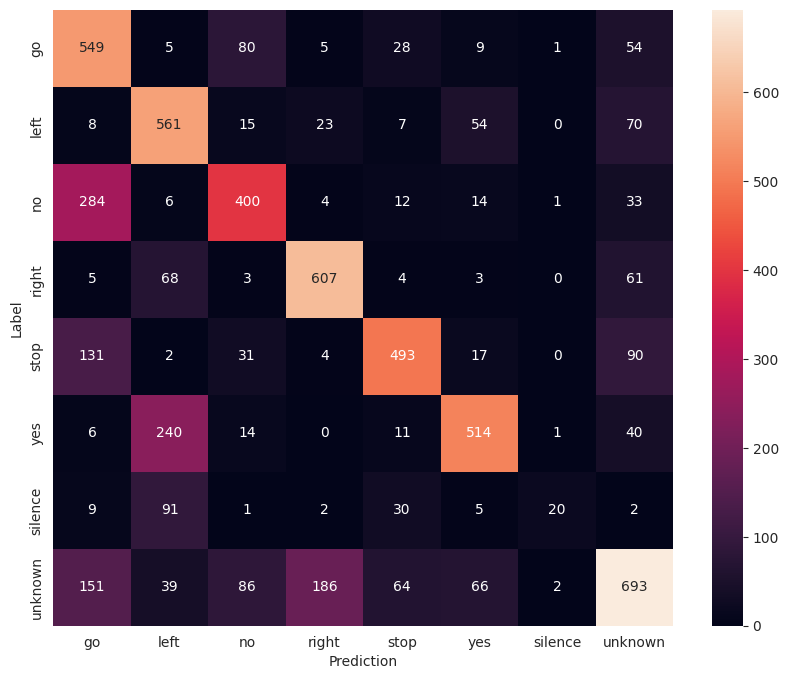

In [204]:
confusion_mtx = tf.math.confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [5]:
label_strings = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes", "silence", "unknown"]
selected_labels = [1, 2, 3, 6, 7, 9, 10, 11]
selected_labels_dict = {x:i for i, x in enumerate(selected_labels)}

In [6]:
selected_labels_str = [label_strings[x] for x in selected_labels]

In [7]:
prediction_dict = {i: label for i, label in enumerate(selected_labels_str)}
prediction_dict_reversed = {label: i for i, label in enumerate(selected_labels_str)}

In [8]:
import os

In [9]:
directory_path = "../Data_acquisition/data/audio/8kHz_sampling"
file_list = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

In [10]:
import csv

# Load data from the microphone

In [11]:
samples = []
labels = []

for file_name in file_list:
    with open(os.path.join(directory_path, file_name), 'r') as file:
        file_data = []
        reader = csv.DictReader(file)
        for row in reader:
            file_data.append(float(row['y']))  # Convert to int if y is numeric
            
        label_str = file_name.split("_")[0]
        if len(file_data) == 8e3:
            labels.append(prediction_dict_reversed.get(label_str))
            samples.append(file_data)

In [12]:
file_list

['stop_fs=8kHz_5.csv',
 'left_fs=8kHz_2.csv',
 'no_fs=8kHz_2.csv',
 'unknown_fs=8kHz_11.csv',
 'right_fs=8kHz_1.csv',
 'go_fs=8kHz_2.csv',
 'unknown_fs=8kHz_9.csv',
 'go_fs=8kHz_1.csv',
 'go_fs=8kHz_11.csv',
 'right_fs=8kHz_8.csv',
 'silence_fs=8kHz_6.csv',
 'yes_fs=8kHz_8.csv',
 'silence_fs=8kHz_10.csv',
 'silence_fs=8kHz_2.csv',
 'unknown_fs=8kHz_5.csv',
 'yes_fs=8kHz_7.csv',
 'right_fs=8kHz_5.csv',
 'right_fs=8kHz_3.csv',
 'silence_fs=8kHz_8.csv',
 'yes_fs=8kHz_12.csv',
 'right_fs=8kHz_7.csv',
 'yes_fs=8kHz_2.csv',
 'silence_fs=8kHz_5.csv',
 'yes_fs=8kHz_1.csv',
 'left_fs=8kHz_8.csv',
 'right_fs=8kHz_6.csv',
 'left_fs=8kHz_5.csv',
 'yes_fs=8kHz_4.csv',
 'stop_fs=8kHz_1.csv',
 'yes_fs=8kHz_6.csv',
 'stop_fs=8kHz.csv',
 'silence_fs=8kHz_12.csv',
 'unknown_fs=8kHz_10.csv',
 'go_fs=8kHz_9.csv',
 'left_fs=8kHz_4.csv',
 'unknown_fs=8kHz_8.csv',
 'stop_fs=8kHz_4.csv',
 'go_fs=8kHz_4.csv',
 'go_fs=8kHz_13.csv',
 'silence_fs=8kHz_4.csv',
 'no_fs=8kHz.csv',
 'stop_fs=8kHz_11.csv',
 'no_fs=8kH

In [13]:
labels

[4,
 1,
 2,
 7,
 3,
 0,
 7,
 0,
 0,
 3,
 6,
 5,
 6,
 6,
 7,
 5,
 3,
 3,
 6,
 5,
 3,
 5,
 6,
 5,
 1,
 3,
 1,
 5,
 4,
 5,
 4,
 6,
 7,
 0,
 1,
 7,
 4,
 0,
 0,
 6,
 2,
 4,
 2,
 3,
 4,
 4,
 0,
 7,
 2,
 1,
 1,
 6,
 4,
 2,
 6,
 5,
 1,
 1,
 0,
 6,
 6,
 4,
 7,
 0,
 3,
 5,
 7,
 2,
 2,
 5,
 1,
 7,
 6,
 3,
 0,
 2,
 2,
 7,
 6,
 1,
 4,
 1,
 5,
 2,
 5,
 0,
 2,
 0,
 5,
 2,
 4,
 0,
 1,
 4,
 6,
 1,
 0,
 7]

In [14]:
samples = np.array(samples)

In [15]:
display.Audio(samples[25], rate=8000)

In [16]:
samples.shape

(98, 8000)

In [17]:
microphone_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in samples]).astype(np.float32)

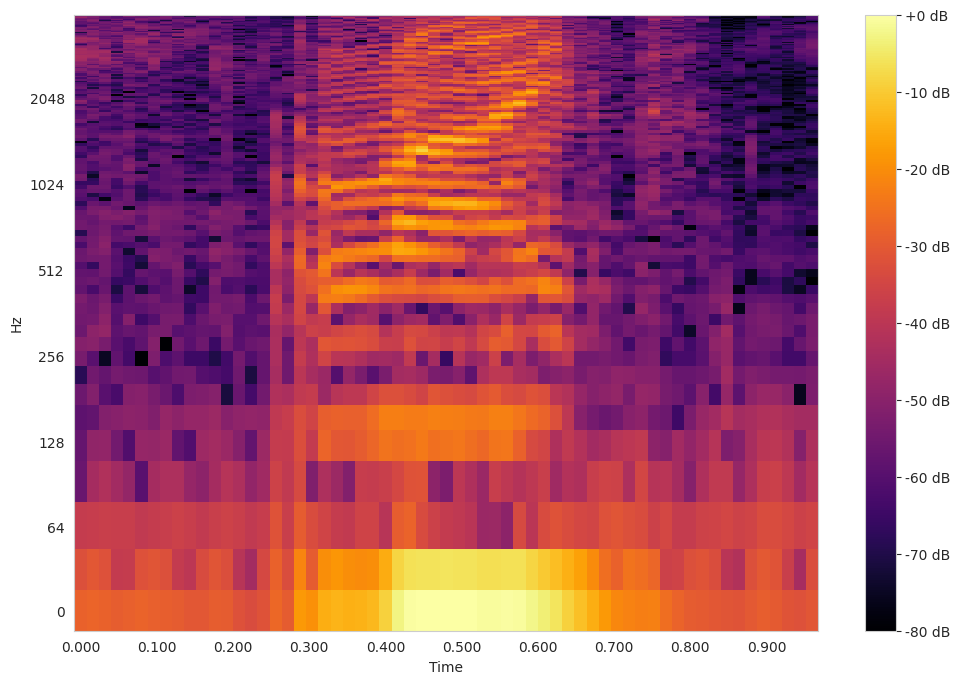

In [18]:
S_db = librosa.amplitude_to_db(np.abs(microphone_data[25]), ref=np.max)
# Plot the spectrogram
plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=8e3, cmap='inferno', hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

In [19]:
microphone_data.shape

(98, 129, 61)

In [20]:
microphone_data_resized = microphone_data.reshape(len(microphone_data), microphone_data.shape[1], microphone_data.shape[2], 1)

In [21]:
microphone_data_resized = tf.image.resize(microphone_data_resized, [32, 32])

I0000 00:00:1737157767.393563   86915 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1817 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 Super, pci bus id: 0000:01:00.0, compute capability: 7.5


In [22]:
microphone_data_resized.shape

TensorShape([98, 32, 32, 1])

In [23]:
y_pred = []
correctly = 0
for sample, y_true in zip(microphone_data_resized, labels):
    interpreter.set_tensor(input_details[0]['index'], tf.expand_dims(sample, 0))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # print(output_data[0].shape)
    
    
    # print(output_data)
    predicted_class = np.argmax(output_data)
    if predicted_class == y_true:
        correctly += 1
    y_pred.append(predicted_class)
    print(f"Y_pred={predicted_class} | Y_true={y_true}")
    print(output_data[0])

Y_pred=4 | Y_true=4
[0.14453125 0.01953125 0.26171875 0.015625   0.37890625 0.08984375
 0.         0.08203125]
Y_pred=7 | Y_true=1
[0.09765625 0.12890625 0.08203125 0.2265625  0.01953125 0.03125
 0.0390625  0.375     ]
Y_pred=0 | Y_true=2
[0.21484375 0.06640625 0.125      0.14453125 0.05078125 0.03125
 0.21484375 0.15625   ]
Y_pred=7 | Y_true=7
[0.06640625 0.0078125  0.05078125 0.00390625 0.01953125 0.09765625
 0.00390625 0.75390625]
Y_pred=3 | Y_true=3
[0.1015625  0.05859375 0.08984375 0.27734375 0.0234375  0.0390625
 0.1328125  0.27734375]
Y_pred=2 | Y_true=0
[0.30078125 0.         0.55078125 0.0078125  0.0390625  0.01953125
 0.         0.08203125]
Y_pred=5 | Y_true=7
[0.0703125  0.04296875 0.265625   0.00390625 0.03515625 0.3515625
 0.12109375 0.10546875]
Y_pred=0 | Y_true=0
[0.43359375 0.0078125  0.078125   0.01171875 0.12109375 0.01953125
 0.01171875 0.31640625]
Y_pred=0 | Y_true=0
[0.359375   0.03125    0.1171875  0.05859375 0.13671875 0.02734375
 0.01171875 0.2578125 ]
Y_pred=3 

In [24]:
print(f"Accuracy: {(correctly/len(labels))*100:.2f}%")

Accuracy: 65.31%


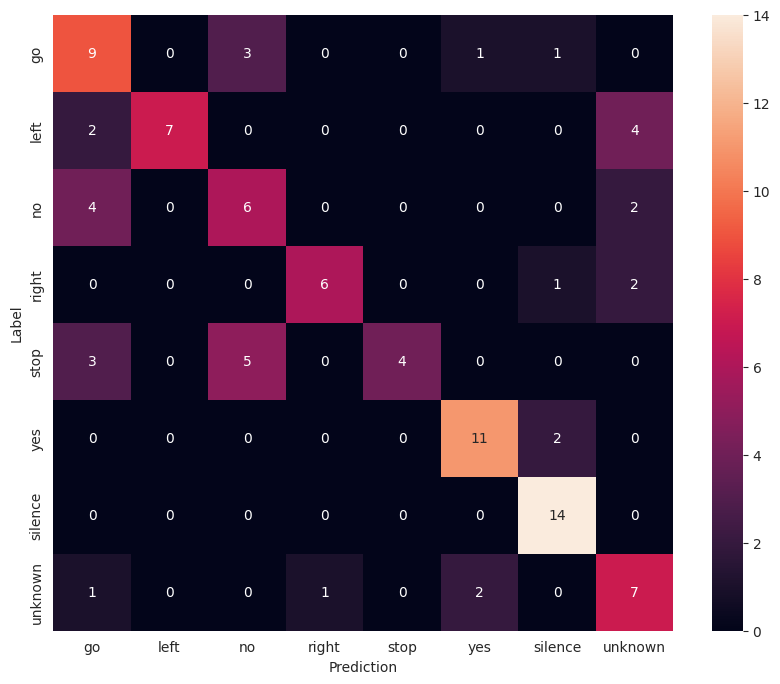

In [25]:
confusion_mtx = tf.math.confusion_matrix(labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()